# TimeSeries チュートリアル

このチュートリアルでは、**GWExPy** の `TimeSeries` クラスの機能を紹介します。

GWExPy の `TimeSeries` は `gwpy.timeseries.TimeSeries` を継承・拡張し、高度な信号処理、統計解析、および最新のデータサイエンスライブラリとのシームレスな相互運用性を提供します。

## 目次
1. [データの生成と基本プロット](#data-gen)
2. [信号処理 (ヒルベルト変換、包絡線、復調)](#signal-proc)
3. [スペクトル解析 (PSD, 伝達関数, コヒーレンス)](#spectral)
4. [統計と前処理 (欠損値補完, 白色化)](#stats)
5. [リサンプリングとアライメント](#resampling)
6. [相互運用性 (Pandas, Xarray, PyTorch)](#interop)

<a id="data-gen"></a>
## 1. データの生成と基本プロット

まずは合成データを生成してみましょう。以下の2つの信号を作成します：
*   **信号 1**: 10Hz のサイン波にガウスノイズを加えたもの。
*   **信号 2**: チャープ信号 (5Hzから25Hzへスイープ) に指数減衰エンベロープを掛けたもの。

チャープ信号は以下のように記述されます：

$$
x(t) = A e^{-t/\tau} \sin\left(2\pi \int_0^t f(t') dt'\right)
$$

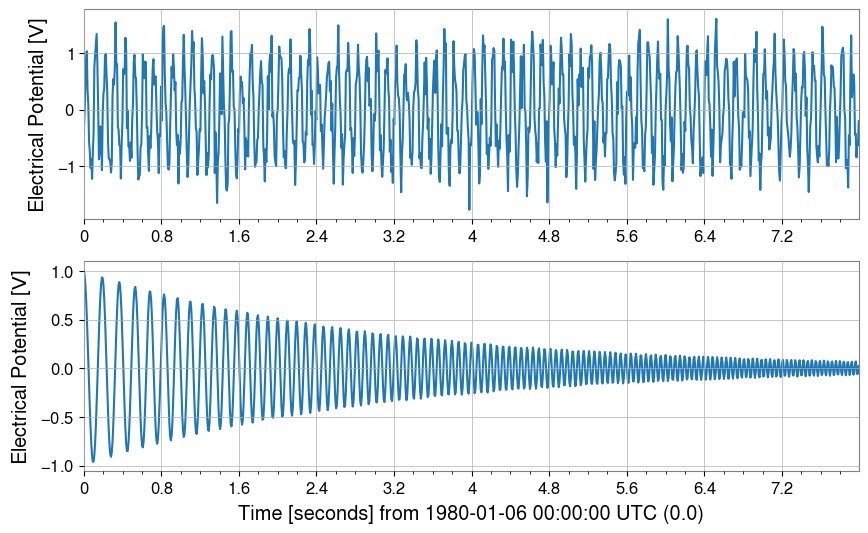

In [1]:
import numpy as np

from gwexpy.noise.wave import chirp, exponential, gaussian, sine
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries

# 設定
fs = 128  # サンプリング周波数 (Hz)
duration = 8.0  # 期間 (秒)

# 信号 1: サイン波 + ノイズ
s1 = sine(duration=duration, sample_rate=fs, frequency=10, amplitude=1.0)
n1 = gaussian(duration=duration, sample_rate=fs, std=0.3)
ts1 = s1 + n1
ts1.name = 'Noisy Sine'
ts1.override_unit('V')

# 信号 2: チャープ * エンベロープ
# 5Hz から 25Hz へのチャープ
s2 = chirp(duration=duration, sample_rate=fs, f0=5, f1=25, t1=duration)
# 指数減衰エンベロープ
env = exponential(duration=duration, sample_rate=fs, tau=3.0, decay=True, amplitude=1.0)
ts2 = s2 * env
ts2.name = 'Chirp Signal'
ts2.override_unit('V')

# GWExPy Plot を使ったプロット
plot = Plot(ts1, ts2, separate=True, sharex=True, figsize=(10, 6))
plot.show()

<a id="signal-proc"></a>
## 2. 信号処理

GWExPy には古典的な信号処理ツールが `TimeSeries` オブジェクトに直接統合されています。

### ヒルベルト変換と包絡線 (Envelope)

解析信号 $x_a(t)$ はヒルベルト変換 $\mathcal{H}[x(t)]$ を用いて以下のように構成されます：

$$
x_a(t) = x(t) + i\mathcal{H}[x(t)] = A(t) e^{i\phi(t)}
$$

ここで $A(t)$ は瞬時振幅 (包絡線)、$\phi(t)$ は瞬時位相です。

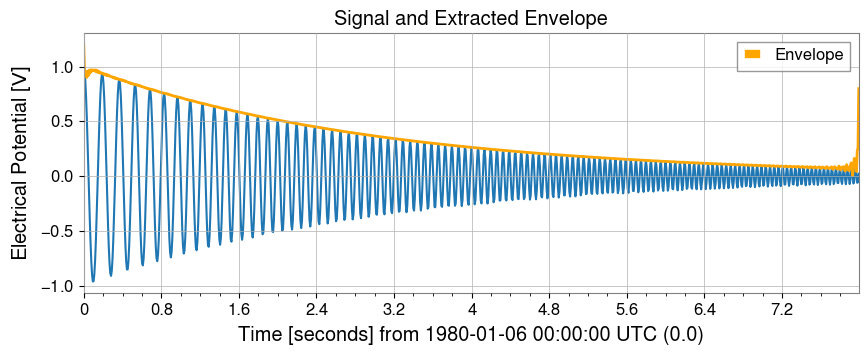

In [2]:
# 解析信号と包絡線の計算
ts_analytic = ts2.hilbert()
ts_envelope = ts2.envelope()

# 信号の上に包絡線をプロット
plot = Plot(ts2, ts_envelope, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[1].set_color('orange')
ax.get_lines()[1].set_linewidth(2)
ax.get_lines()[1].set_label('Envelope')
ax.legend()
ax.set_title('Signal and Extracted Envelope')
plot.show()

### 瞬時周波数

瞬時周波数は位相の時間微分として定義されます：

$$
f(t) = \frac{1}{2\pi} \frac{d\phi(t)}{dt}
$$

GWExPy は位相のアンラップと微分を自動的に処理します。

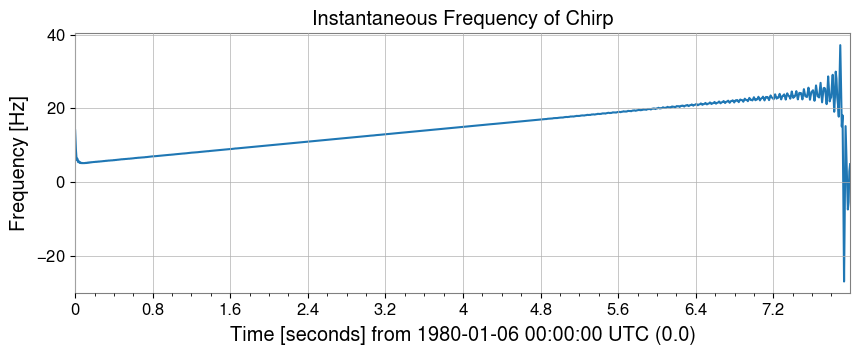

In [3]:
# 瞬時周波数の計算
ts_inst_freq = ts2.instantaneous_frequency()

plot = Plot(ts_inst_freq, figsize=(10, 4))
plot.gca().set_ylabel('Frequency [Hz]')
plot.gca().set_title('Instantaneous Frequency of Chirp')
plot.show()

<a id="spectral"></a>
## 3. スペクトル解析

### パワー・スペクトル・密度 (PSD)

Welch法を用いて PSD を計算します。ウィンドウ関数、セグメント長、オーバーラップを指定可能です。

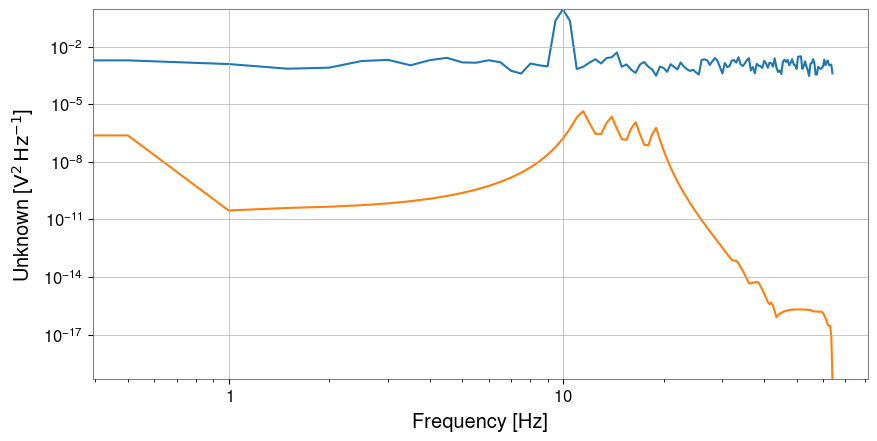

In [4]:
# PSD の計算
psd1 = ts1.psd(fftlength=2, overlap=1, window='hann')
psd2 = ts2.psd(fftlength=2, overlap=1, window='hann')

# PSD のプロット
plot = Plot(psd1, psd2, xscale='log', yscale='log', figsize=(10, 5))
plot.show()

<a id="stats"></a>
## 4. 統計と前処理

### 欠損値補完 (Imputation)

実データにはギャップ (NaN) が含まれることがよくあります。`impute()` はこれらを埋めるための様々な手法を提供します。

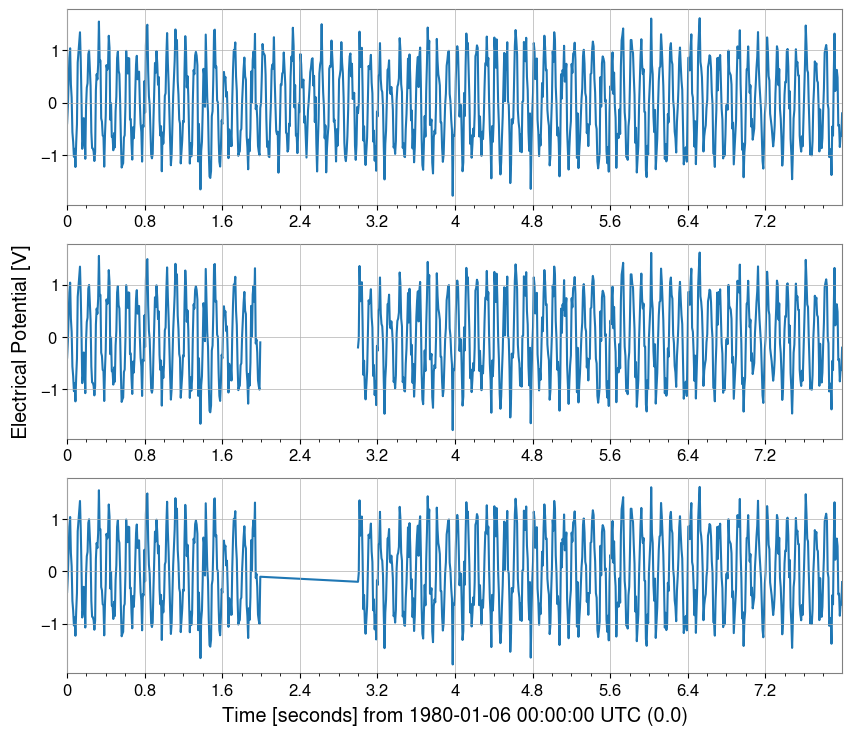

In [5]:
# ギャップのあるデータを作成
ts_gapped = ts1.copy()
ts_gapped[int(fs*2):int(fs*3)] = np.nan  # 1秒間のギャップ

# 線形補間による穴埋め
ts_imputed = ts_gapped.impute(method='linear')

plot = Plot(ts1, ts_gapped, ts_imputed, separate=True, sharex=True, figsize=(10, 8))
plot.show()

<a id="interop"></a>
## 5. 相互運用性

GWExPy は Python のデータサイエンスエコシステムにスムーズに適合します。

### Pandas DataFrame

Pandas DataFrame との相互変換が簡単に行えます。

In [6]:
df = ts1.to_pandas()
print(df.head())

# TimeSeries への復元
ts_from_df = TimeSeries.from_pandas(df)
print(ts_from_df)

time_utc
1980-01-06 00:00:19+00:00          -0.394519
1980-01-06 00:00:19.007812+00:00   -0.081246
1980-01-06 00:00:19.015625+00:00    0.400910
1980-01-06 00:00:19.023438+00:00    0.848243
1980-01-06 00:00:19.031250+00:00    1.036210
Name: Noisy Sine, dtype: float64


TimeSeries([-0.39451887, -0.0812462 ,  0.40091044, ...,
            -0.61998517, -0.63361337, -0.20540171]
           unit: dimensionless,
           t0: 19.0 s,
           dt: 0.007812000000001262 s,
           name: Noisy Sine,
           channel: None)


### PyTorch / TensorFlow / JAX

機械学習アプリケーションのために、直接テンソルへ変換できます。

In [7]:
# PyTorch Tensor への変換
try:
    tensor = ts1.to_torch()
    print(f"PyTorch Tensor shape: {tensor.shape}")
except ImportError:
    print("PyTorch not installed.")

PyTorch Tensor shape: torch.Size([1024])
